In [1]:
#!/usr/bin/python
#-*- encoding:utf-8 -*-
import os
import re
import numpy as np
from numpy import *
from gensim.models import word2vec
from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import jieba
jieba.load_userdict('/Users/lyj/Desktop/提案程序/sogou.txt')
jieba.load_userdict('/Users/lyj/Desktop/提案程序/标题补充词典.txt')

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/x_/43mxrf_j66q5ynk5hsxw14lw0000gn/T/jieba.cache
Loading model cost 0.764 seconds.
Prefix dict has been built succesfully.


In [2]:
#读取stop停用词  
def readstopwords(stopwords_path): 
    stop_single_words=[]  
    with open(stopwords_path,'r+',encoding='utf-8') as lines:
        for line in lines:  
            content=line.strip()  
            stop_single_words.append(content) 
    return stop_single_words

#把文档中的所有文件名字存入数组
def getFilelist(path):
    txtNames = []                     #所有txt文档名字
    pathDir = os.listdir(path) #把文件夹里的所有txt文档的名字都获取了，放入数组
    for allDir in pathDir:
        if(allDir.find('txt') >= 0 and allDir.find('result') < 0):
            txtNames.append(allDir)
    return txtNames 

#具体的分词程序
def fenci(filePath,filename,stop_single_words) :
    f = open(filePath+'/'+filename,'r+',encoding='utf-8')
    file_list = f.read()
    f.close()
    #正则化必须去除字母数字百分数，不然计算的TF-IDF在用来求提案质心时会出错
    #错误类型：ValueError: 'GDP' is not in list
    file_list=re.sub('[A-Za-z0-9,\d+(\.\d+)?\%]','',file_list) #去除字母,数字,百分数
    #file_list=re.sub('[0-9,\d+(\.\d+)?\%]','',file_list)
    
    lis=[] #保存分词结果
    seg_list = jieba.cut(file_list,cut_all=False)
    for seg in seg_list : 
        seg = ''.join(seg.split())
        if seg not in stop_single_words and len(seg)!=1: #为什么计算质心的时候不能有单字词
            lis.append(seg)  
    return lis

#保存每篇提案的分词结果
def save_word_seg_result(filename,word_seg_result,save_word_seg_path):
    f = open(save_word_seg_path+"/"+filename,"w+",encoding='utf-8')
    f.write(' '.join(word_seg_result))
    f.close()
    return

#对整个文档分词
def Participle(filePath,key_path,save_word_seg_path,stop_single_words):   
    word_count={}    #存放所有提案的 词-数量 键值对
    reserved_words=[] #存放用于计算质心的词，也就是用于训练词向量的词
    doc_name_words={} #保存所有提案的 名字-分词结果 键值对
    sentences=[] #嵌套列表，保存每篇提案的分词结果
    allfile = getFilelist(filePath) #获取所有提案的文件名
    allfile1 = getFilelist(key_path)
    allfile.extend(allfile1)
    
    for file in allfile:
        try:
            word_seg_result=fenci(filePath,file,stop_single_words)  #对每个提案分词
        except:
            word_seg_result=fenci(key_path,file,stop_single_words)
        sentences.append(word_seg_result)
        for word in word_seg_result:  #统计所有提案中每个词的数量
            if word not in word_count.keys():
                word_count[word]=1
            else:
                word_count[word]+=1
        doc_name_words[file]=word_seg_result #将提案名和词按字典保存
    doc_name_words_new={}
    for key in doc_name_words.keys():
        word_list=[]
        for word_ in doc_name_words[key]:
            if word_count[word_]>1:
                word_list.append(word_)
        #保存分词结果，平时注释掉
        save_word_seg_result(key,word_list,save_word_seg_path) 
        doc_name_words_new[key]=word_list
    return doc_name_words_new,sentences,allfile

#训练词向量
def train_vec(sentences,dimen):
    model = word2vec.Word2Vec(sentences,min_count=2,size=dimen) #训练词向量
    return model

#读取800份已分词好的文档，进行TF-IDF计算。
#这里是去除停用词的所有词，且删除了出现次数小于某一阈值的词
def Tfidf(path,filelist):
    corpus = []  #存取800份文档的分词结果
    for ff in filelist :
        fname = path +"/"+ff
        f = open(fname,"r+",encoding="utf-8")
        content = f.read()
        corpus.append(content)
        f.close()

    vectorizer = CountVectorizer()    
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(vectorizer.fit_transform(corpus))
    tfidf_word = vectorizer.get_feature_names() #所有文本的分词词语
    tfidf_weight = tfidf.toarray()              #对应的tfidf矩阵
    return tfidf_word,tfidf_weight.tolist()

#计算每篇文档的质心
#doc_name_words中的词删除了停用词和小于某一阈值（出现次数小于1）的词
#reserved_words中的词删除了停用词和出现次数小于某一阈值的词
def centroid_TF(doc_name_words,model,allfile,tfidf_word,tfidf_weight,dimen):
    doc_vec_list=[]
    doc_vec_dic={}
    for name in doc_name_words.keys():
        sum_value=np.mat(zeros((1,dimen)))
        count=0
        for word in doc_name_words[name]:
            weight=tfidf_weight[allfile.index(name)][tfidf_word.index(word)]
            count+=1
            sum_value+=np.mat(model[word])*weight #词向量*权重
            #print(tfidf_weight[allfile.index(name)][tfidf_word.index(word)])
        doc_vec_list.append(((sum_value/count).tolist())[0]) #这两处必须转化为列表，如果是数组，后面聚类程序保存文件的循环出错
        doc_vec_dic[name]=((sum_value/count).tolist())[0]
    return doc_vec_list,doc_vec_dic



In [3]:
stopwords="/Users/lyj/Desktop/提案程序/百度停用词列表（去除英文）+tycb_symbol.txt"  
filePath = "/Users/lyj/Desktop/提案程序/提案数据"  #txt文本集所在的文件夹路径
key_path="/Users/lyj/Desktop/关键词文档"
save_word_seg_path="/Users/lyj/Desktop/提案程序/关键词文档" #保存分词结果的路径

stop_single_words=readstopwords(stopwords)
doc_name_words,sentences,allfile=Participle(filePath,key_path,save_word_seg_path,stop_single_words) #对整个文档分词
tfidf_word,tfidf_weight=Tfidf(save_word_seg_path,allfile)
dimen=300 #词向量维度
model=train_vec(sentences,dimen)
#求每篇文档的质心
#这是一条说明语句doc_vec_list,doc_vec_dic=centroid_TF(doc_name_words,reserved_words,model,allfile,tfidf_word,tfidf_weight,threshold,weight,title_seg_lis)
doc_vec_list,doc_vec_dic=centroid_TF(doc_name_words,model,allfile,tfidf_word,tfidf_weight,dimen)
print(len(doc_vec_list))

    

/Applications/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:112: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


814


In [4]:
from scipy.spatial.distance import pdist
key_path_1="/Users/lyj/Desktop/关键词文档1"
cluster_out_path="/Users/lyj/Desktop/提案程序/word2veccluster（终极版）"
key_name = getFilelist(key_path_1)
cluster_out_name=getFilelist(cluster_out_path)
dic1={}
for name in key_name:
    for file_name in cluster_out_name:
        if name==file_name:
            l_list=[]
            doc_name_list = getFilelist(cluster_out_path+"/"+file_name)
            for name2 in doc_name_list:
                l=np.sqrt(np.sum(np.square(np.mat(doc_vec_dic[name]) - np.mat(doc_vec_dic[name2]))))
                #dist = pdist(np.vstack([np.mat(doc_vec_dic[name]),np.mat(doc_vec_dic[name2])]),'cosine')
                l_list.append(l)
    if name=="1.txt":
        dic1[1]=[round(mean(l_list),3),len(l_list)]
    if name=="2.txt":
        dic1[2]=[round(mean(l_list),3),len(l_list)]
    if name=="3.txt":
        dic1[3]=[round(mean(l_list),3),len(l_list)]
    if name=="4.txt":
        dic1[4]=[round(mean(l_list),3),len(l_list)]
    if name=="5.txt":
        dic1[5]=[round(mean(l_list),3),len(l_list)]
    if name=="6.txt":
        dic1[6]=[round(mean(l_list),3),len(l_list)]
    if name=="7.txt":
        dic1[7]=[round(mean(l_list),3),len(l_list)]
    if name=="8.txt":
        dic1[8]=[round(mean(l_list),3),len(l_list)]
        
for iii in sorted(dic1.items(),key = lambda x:x[0]):
    print("短词，主题"+str(iii[0])+"的微博文档与主题"+str(iii[0])+"对应提案的欧式距离:",iii[1][0],"  ","主题"+str(iii[0])+"的提案数:",iii[1][1])
        

短词，主题1的微博文档与主题1对应提案的欧式距离: 0.197    主题1的提案数: 68
短词，主题2的微博文档与主题2对应提案的欧式距离: 0.187    主题2的提案数: 78
短词，主题3的微博文档与主题3对应提案的欧式距离: 0.533    主题3的提案数: 3
短词，主题4的微博文档与主题4对应提案的欧式距离: 0.138    主题4的提案数: 432
短词，主题5的微博文档与主题5对应提案的欧式距离: 0.181    主题5的提案数: 85
短词，主题6的微博文档与主题6对应提案的欧式距离: 0.18    主题6的提案数: 57
短词，主题7的微博文档与主题7对应提案的欧式距离: 0.172    主题7的提案数: 60
短词，主题8的微博文档与主题8对应提案的欧式距离: 0.13    主题8的提案数: 15


In [5]:
from scipy.spatial.distance import pdist
key_path_2="/Users/lyj/Desktop/关键词文档2"
cluster_out_path2="/Users/lyj/Desktop/提案程序/word2veccluster（终极版）的副本"
key_name2 = getFilelist(key_path_2)
cluster_out_name2=getFilelist(cluster_out_path2)
dic2={}
for name1 in key_name2:
    for file_name2 in cluster_out_name2:
        if name1==file_name2:
            l_list2=[]
            doc_name_list2 = getFilelist(cluster_out_path2+"/"+file_name2)
            for name22 in doc_name_list2:
                l2=np.sqrt(np.sum(np.square(np.mat(doc_vec_dic[name1]) - np.mat(doc_vec_dic[name22]))))
                #dist2 = pdist(np.vstack([np.mat(doc_vec_dic[name1]),np.mat(doc_vec_dic[name22])]),'cosine')
                l_list2.append(l2)
    if name1=="11.txt":
        dic2[1]=[round(mean(l_list2),3),len(l_list2)]
    if name1=="22.txt":
        dic2[2]=[round(mean(l_list2),3),len(l_list2)]
    if name1=="33.txt":
        dic2[3]=[round(mean(l_list2),3),len(l_list2)]
    if name1=="44.txt":
        dic2[4]=[round(mean(l_list2),3),len(l_list2)]
    if name1=="55.txt":
        dic2[5]=[round(mean(l_list2),3),len(l_list2)]
    if name1=="66.txt":
        dic2[6]=[round(mean(l_list2),3),len(l_list2)]
    if name1=="77.txt":
        dic2[7]=[round(mean(l_list2),3),len(l_list2)]
    if name1=="88.txt":
        dic2[8]=[round(mean(l_list2),3),len(l_list2)]
        
for iii2 in sorted(dic2.items(),key = lambda x:x[0]):
    print("长词，主题"+str(iii2[0])+"的微博文档与主题"+str(iii2[0])+"对应提案的欧式距离:",iii2[1][0],"  ","主题"+str(iii2[0])+"的提案数:",iii2[1][1])


长词，主题1的微博文档与主题1对应提案的欧式距离: 0.173    主题1的提案数: 68
长词，主题2的微博文档与主题2对应提案的欧式距离: 0.162    主题2的提案数: 78
长词，主题3的微博文档与主题3对应提案的欧式距离: 0.376    主题3的提案数: 3
长词，主题4的微博文档与主题4对应提案的欧式距离: 0.123    主题4的提案数: 432
长词，主题5的微博文档与主题5对应提案的欧式距离: 0.164    主题5的提案数: 85
长词，主题6的微博文档与主题6对应提案的欧式距离: 0.175    主题6的提案数: 57
长词，主题7的微博文档与主题7对应提案的欧式距离: 0.14    主题7的提案数: 60
长词，主题8的微博文档与主题8对应提案的欧式距离: 0.125    主题8的提案数: 15


/Applications/anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


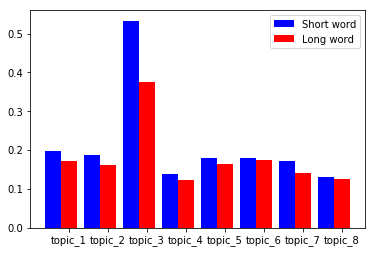

In [23]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
 
name_list = ['topic_1','topic_2','topic_3','topic_4','topic_5','topic_6','topic_7','topic_8']
num_list = [0.197,0.187,0.533,0.138,0.181,0.180,0.172,0.13]
num_list1 = [0.173,0.162,0.376,0.123,0.164,0.175,0.140,0.125]
x =list(range(len(num_list)))
total_width, n = 0.8, 2
width = total_width / n
 
plt.bar(x, num_list, width=width, label='Short word',fc = 'b')
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, num_list1, width=width, label='Long word',tick_label = name_list,fc = 'r')
#plt.yticks([0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6])

# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
# ax.set_title("Similarity between Weibo data of different topics and corresponding proposals")
# ax.set_xlabel("topic")
# ax.set_ylabel("European distance")

plt.legend()
plt.show()

